# Importing libraries

In [2]:
# Import Libraries and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# Configure GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU available: {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available, using CPU")

Libraries imported successfully!
TensorFlow version: 2.19.0
GPU not available, using CPU


# Loading the data

In [3]:
import numpy as np
import joblib
import json

# Load data
X_train = np.load(r"D:\bibAlex-Hackathon-TeamX\data\train\X_train.npy")
y_train = np.load(r"D:\bibAlex-Hackathon-TeamX\data\train\y_train.npy")
X_test = np.load(r"D:\bibAlex-Hackathon-TeamX\data\test\X_test.npy")
y_test = np.load(r"D:\bibAlex-Hackathon-TeamX\data\test\y_test.npy")

# Load scalers
scaler_features = joblib.load(r"D:\bibAlex-Hackathon-TeamX\data\train\scaler_features.pkl")
scaler_target = joblib.load(r"D:\bibAlex-Hackathon-TeamX\data\train\scaler_target.pkl")

# Load metadata
with open(r"D:\bibAlex-Hackathon-TeamX\data\train\meta.json", "r") as f:
    metadata = json.load(f)

feature_cols = metadata["feature_cols"]
target_col = metadata["target_col"]
sequence_length = metadata["sequence_length"]

print("✅ Data and scalers loaded successfully.")

✅ Data and scalers loaded successfully.


# Building the classical model

In [4]:
# Classical Layer Definition (Replaces Quantum Layer)

n_classical_layers = 4  # Number of classical processing layers
print(f"Classical Configuration:")
print(f"- Number of classical processing layers: {n_classical_layers}")

class ClassicalProcessingLayer(layers.Layer):
    """
    Classical equivalent of QuantumLayer using dense neural networks
    with non-linear transformations to simulate quantum-like processing
    """
    
    def __init__(self, n_layers=4, d_model=64, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers
        self.d_model = d_model
        
        print(f"Creating ClassicalProcessingLayer with {n_layers} layers")
        
        # Dense layers for dimension transformation
        self.dense_to_processing = layers.Dense(d_model, activation='tanh')
        self.dense_back = layers.Dense(d_model)
        
        # Multiple processing layers to simulate quantum-like transformations
        self.processing_layers = []
        for i in range(n_layers):
            self.processing_layers.append([
                layers.Dense(d_model, activation='tanh', name=f'processing_{i}_1'),
                layers.Dense(d_model, activation='sigmoid', name=f'processing_{i}_2'),
                layers.Dense(d_model, activation='relu', name=f'processing_{i}_3'),
                layers.LayerNormalization(name=f'norm_{i}')
            ])
        
        # Dropout for regularization
        self.dropout = layers.Dropout(0.1)
        
    def call(self, inputs, training=None):
        # Transform input to processing dimension
        x = self.dense_to_processing(inputs)
        
        # Clip inputs to prevent extreme values
        x = tf.clip_by_value(x, -2.0, 2.0)
        
        # Multi-layer classical processing to simulate quantum transformations
        for layer_group in self.processing_layers:
            # Store residual connection
            residual = x
            
            # Apply multiple non-linear transformations
            x1 = layer_group[0](x)  # Tanh transformation
            x2 = layer_group[1](x)  # Sigmoid transformation  
            x3 = layer_group[2](x)  # ReLU transformation
            
            # Combine transformations (simulating quantum superposition)
            x = (x1 + x2 + x3) / 3.0
            
            # Add residual connection and normalize
            x = x + 0.1 * residual  # Weak residual connection
            x = layer_group[3](x)  # Layer normalization
            
            # Apply dropout during training
            x = self.dropout(x, training=training)
        
        # Final bounded output
        x = tf.nn.tanh(x)
        
        # Check for NaN and replace with zeros if found
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        
        # Transform back to model dimension
        return self.dense_back(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_layers": self.n_layers,
            "d_model": self.d_model
        })
        return config

# Test the classical processing layer
print("Testing classical processing layer...")
test_input = tf.random.normal((16, 25))  # batch_size=16, d_model=25
classical_layer = ClassicalProcessingLayer(
    n_layers=n_classical_layers,
    d_model=25
)
test_output = classical_layer(test_input)
print(f"Classical layer test - Input shape: {test_input.shape}, Output shape: {test_output.shape}")
print("Classical processing layer working correctly!")
print("="*50)

Classical Configuration:
- Number of classical processing layers: 4
Testing classical processing layer...
Creating ClassicalProcessingLayer with 4 layers
Classical layer test - Input shape: (16, 25), Output shape: (16, 25)
Classical processing layer working correctly!


In [5]:
# Classical Transformer Architecture

class MultiHeadClassicalAttention(layers.Layer):
    """
    Classical multi-head attention with additional processing layers
    """
    
    def __init__(self, d_model, num_heads, n_layers=4, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.n_layers = n_layers
        
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        # Classical processing layer for attention enhancement
        self.classical_attention = ClassicalProcessingLayer(n_layers, d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None, training=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention = tf.matmul(attention_weights, v)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.d_model))
        
        # Apply classical processing to attention
        classical_attention = self.classical_attention(concat_attention, training=training)
        
        output = self.dense(classical_attention)
        
        return output, attention_weights

class ClassicalTransformerBlock(layers.Layer):
    """
    Transformer block with classical processing layers
    """
    
    def __init__(self, d_model, num_heads, dff, n_layers=4, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        
        self.att = MultiHeadClassicalAttention(d_model, num_heads, n_layers)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
        # Additional classical processing layer
        self.classical_ffn = ClassicalProcessingLayer(n_layers, d_model)
    
    def call(self, x, training=None, mask=None):
        attn_output, _ = self.att(x, x, x, mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        classical_output = self.classical_ffn(ffn_output, training=training)
        ffn_output = self.dropout2(classical_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def create_classical_transformer_model(sequence_length, n_features, d_model=25, num_heads=4, 
                                     num_layers=2, dff=128, n_processing_layers=4):
    """
    Create classical transformer model (equivalent to quantum transformer)
    """
    
    print(f"Creating model with:")
    print(f"  - Classical processing layers: {n_processing_layers}")
    print(f"  - Transformer layers: {num_layers}")
    print(f"  - Model dimension: {d_model}")
    
    # Input layer
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # Feature projection
    x = layers.Dense(d_model)(inputs)
    
    # Positional encoding
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(sequence_length, d_model)(positions)
    x = x + pos_encoding
    
    # Classical transformer blocks
    for i in range(num_layers):
        transformer_block = ClassicalTransformerBlock(d_model, num_heads, dff, n_processing_layers)
        x = transformer_block(x)
        print(f"  - Added classical transformer block {i+1}")
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classical processing
    x = ClassicalProcessingLayer(n_processing_layers, d_model//2)(x)
    
    # Output layers
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [6]:
# Model Creation and Training Setup

# Create the classical transformer model
print("Creating Classical Transformer model...")
n_features = X_train.shape[2]
seq_len = X_train.shape[1]

# Classical configuration (equivalent to quantum config)
CLASSICAL_CONFIG = {
    'n_processing_layers': 4,  # Replaces n_qubits and n_q_reps
    'd_model': 64,             # Model dimension
    'num_heads': 4,            # Attention heads
    'num_layers': 5,           # Transformer layers
    'dff': 128                 # Feed-forward dimension
}

print(f"Classical Configuration: {CLASSICAL_CONFIG}")

model = create_classical_transformer_model(
    sequence_length=seq_len,
    n_features=n_features,
    **CLASSICAL_CONFIG
)

print("Model created successfully!")
print(f"Input shape: ({seq_len}, {n_features})")
model.summary()

Creating Classical Transformer model...
Classical Configuration: {'n_processing_layers': 4, 'd_model': 64, 'num_heads': 4, 'num_layers': 5, 'dff': 128}
Creating model with:
  - Classical processing layers: 4
  - Transformer layers: 5
  - Model dimension: 64
Creating ClassicalProcessingLayer with 4 layers
Creating ClassicalProcessingLayer with 4 layers

  - Added classical transformer block 1
Creating ClassicalProcessingLayer with 4 layers
Creating ClassicalProcessingLayer with 4 layers
  - Added classical transformer block 2
Creating ClassicalProcessingLayer with 4 layers
Creating ClassicalProcessingLayer with 4 layers
  - Added classical transformer block 3
Creating ClassicalProcessingLayer with 4 layers
Creating ClassicalProcessingLayer with 4 layers
  - Added classical transformer block 4
Creating ClassicalProcessingLayer with 4 layers
Creating ClassicalProcessingLayer with 4 layers
  - Added classical transformer block 5
Creating ClassicalProcessingLayer with 4 layers
Model created

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7, 64)          │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_transformer_block     │ (None, 7, 64)          │       150,976 │
│ (ClassicalTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_transformer_block_1   │ (None, 7, 64)          │       150,976 │
│ (ClassicalTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_transformer_block_2   │ (None, 7, 64)          │       150,976 │
│ (ClassicalTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_transformer_block_3   │ (None, 7, 64)          │       150,976 │
│ (ClassicalTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_transformer_block_4   │ (None, 7, 64)          │       150,976 │
│ (ClassicalTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classical_processing_layer_11   │ (None, 32)             │        16,064 │
│ (ClassicalProcessingLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773,697 (2.95 MB)

 Trainable params: 773,697 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training Utilities

def compile_model(model, learning_rate=0.0001, clip_norm=1.0):
    optimizer = Adam(learning_rate=learning_rate, clipnorm=clip_norm)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def get_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=5,
            min_lr=1e-8,
            verbose=1
        )
    ]

def clean_data(X_train, y_train, X_test, y_test):
    print(f"NaN in X_train: {np.isnan(X_train).sum()}")
    print(f"NaN in y_train: {np.isnan(y_train).sum()}")
    print(f"NaN in X_test: {np.isnan(X_test).sum()}")
    print(f"NaN in y_test: {np.isnan(y_test).sum()}")
    
    X_train = np.nan_to_num(X_train, nan=0.0)
    y_train = np.nan_to_num(y_train, nan=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0)
    y_test = np.nan_to_num(y_test, nan=0.0)
    
    print("Data cleaned of NaN values")
    return X_train, y_train, X_test, y_test

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [8]:
# Model Training

# Compile model
model = compile_model(model)

# Clean the data
X_train, y_train, X_test, y_test = clean_data(X_train, y_train, X_test, y_test)

# Get callbacks
callbacks = get_callbacks()

NaN in X_train: 0
NaN in y_train: 0
NaN in X_test: 0
NaN in y_test: 0
Data cleaned of NaN values


In [9]:
# Train
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - loss: 0.7401 - mae: 0.6798 - val_loss: 0.2506 - val_mae: 0.3885 - learning_rate: 1.0000e-04
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.3553 - mae: 0.4750 - val_loss: 0.2209 - val_mae: 0.3669 - learning_rate: 1.0000e-04
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.2770 - mae: 0.4136 - val_loss: 0.2082 - val_mae: 0.3584 - learning_rate: 1.0000e-04
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.2473 - mae: 0.3895 - val_loss: 0.2084 - val_mae: 0.3607 - learning_rate: 1.0000e-04
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.2154 - mae: 0.3641 - val_loss: 0.1702 - val_mae: 0.3179 - learning_rate: 1.0000e-04
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.2097 - mae: 0.3580 - val_loss: 0.1591 - val_mae: 0.3082 - learning_rate: 1.0000e-04
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.1960 - mae: 0.3448 - val_loss: 0.1509 - val_mae:

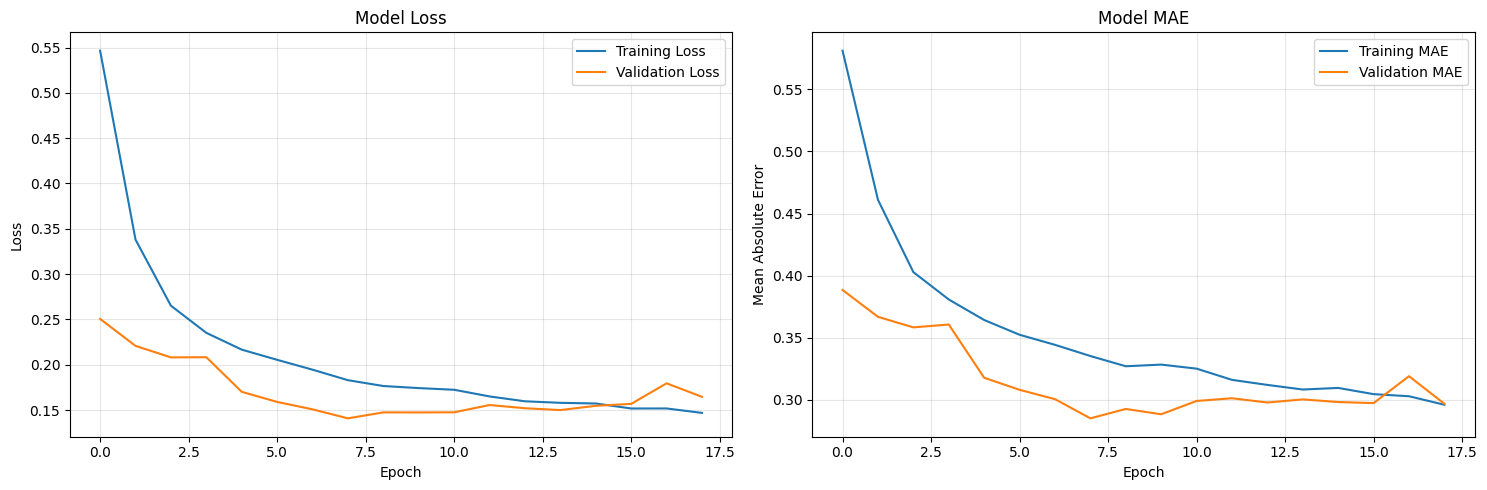

In [38]:
# Plot results
plot_training_history(history)

# Model Evaluation

In [12]:
print("Making predictions...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("Predictions Done")

# Revert scaling to get original values
y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_train_actual = scaler_target.inverse_transform(y_pred_train).flatten()
y_pred_test_actual = scaler_target.inverse_transform(y_pred_test).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    return mse, mae, rmse, r2

train_metrics = calculate_metrics(y_train_actual, y_pred_train_actual, "Training")
test_metrics = calculate_metrics(y_test_actual, y_pred_test_actual, "Test")

Making predictions...
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Predictions Done

Training Metrics:
MSE: 4.6325
MAE: 1.6490
RMSE: 2.1523
R²: 0.8768

Test Metrics:
MSE: 5.4963
MAE: 1.7811
RMSE: 2.3444
R²: 0.8762


# Training & Testing Visualization

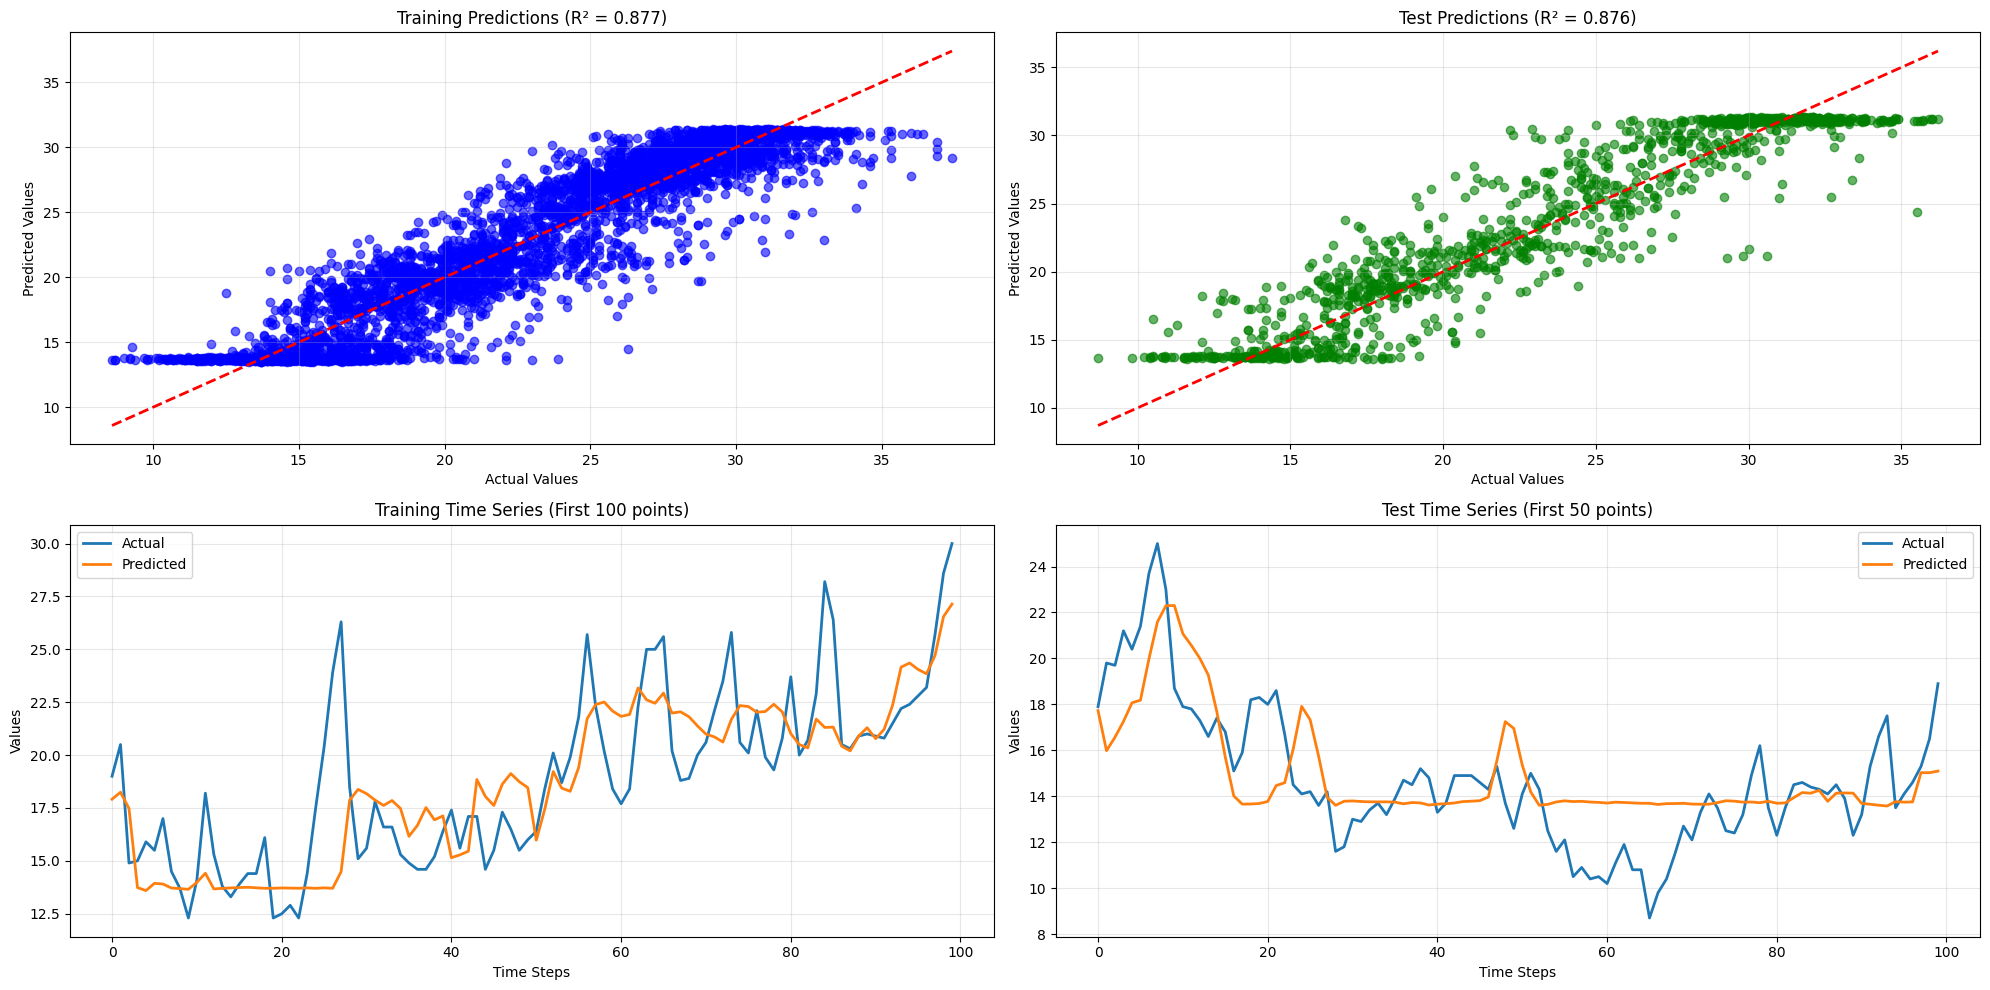

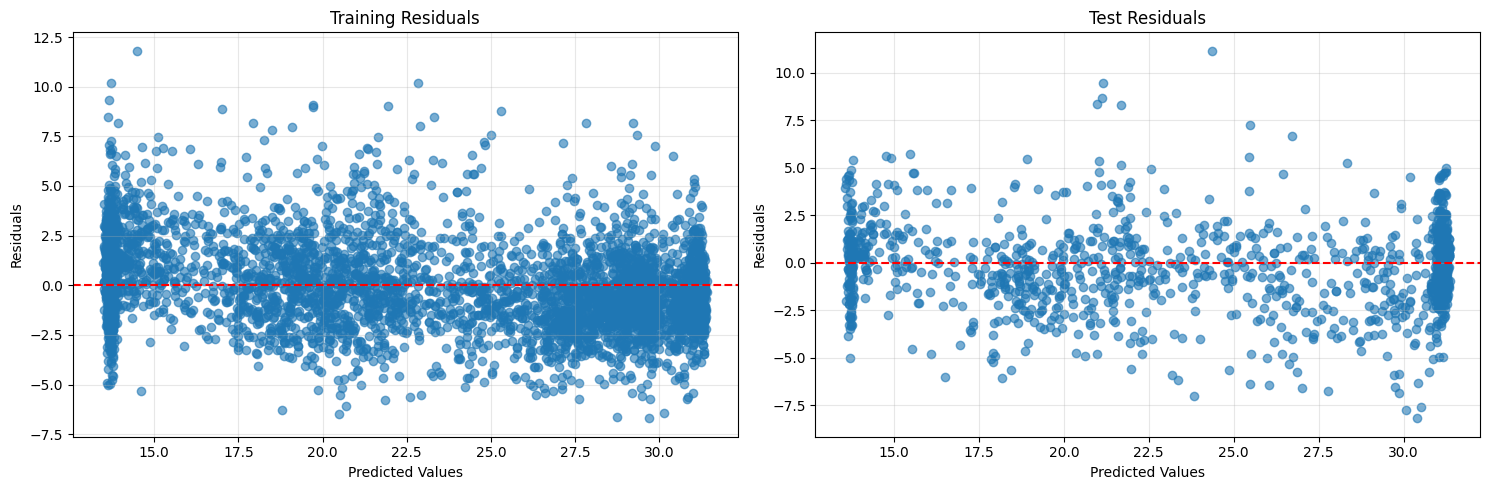

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# (a) Training Predictions Scatter
plt.subplot(2, 2, 1)
plt.scatter(y_train_actual, y_pred_train_actual, alpha=0.6, color='blue')
plt.plot([y_train_actual.min(), y_train_actual.max()],
         [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Training Predictions (R² = {train_metrics[3]:.3f})')
plt.grid(True, alpha=0.3)

# (b) Test Predictions Scatter
plt.subplot(2, 2, 2)
plt.scatter(y_test_actual, y_pred_test_actual, alpha=0.6, color='green')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Test Predictions (R² = {test_metrics[3]:.3f})')
plt.grid(True, alpha=0.3)

# (c) Time Series: Train
plt.subplot(2, 2, 3)
plt.plot(y_train_actual[:100], label='Actual', linewidth=2)
plt.plot(y_pred_train_actual[:100], label='Predicted', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Training Time Series (First 100 points)')
plt.legend()
plt.grid(True, alpha=0.3)

# (d) Time Series: Test
plt.subplot(2, 2, 4)
plt.plot(y_test_actual[:100], label='Actual', linewidth=2)
plt.plot(y_pred_test_actual[:100], label='Predicted', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Test Time Series (First 50 points)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

# (a) Residuals for Train Set
plt.subplot(1, 2, 1)
residuals_train = y_train_actual - y_pred_train_actual
plt.scatter(y_pred_train_actual, residuals_train, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Residuals')
plt.grid(True, alpha=0.3)

# (b) Residuals for Test Set
plt.subplot(1, 2, 2)
residuals_test = y_test_actual - y_pred_test_actual
plt.scatter(y_pred_test_actual, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Forecasting

In [20]:
def forecast_weather(model, last_sequence, scaler_features, scaler_target, n_steps=7):
    """
    Forecast weather for the next n_steps using the trained classical transformer
    """
    forecasted_values = []
    current_sequence = last_sequence.copy()
    
    for step in range(n_steps):
        prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        pred_original = scaler_target.inverse_transform(prediction.reshape(-1, 1))[0, 0]
        forecasted_values.append(pred_original)
        
        if current_sequence.shape[1] > 1:
            new_features = current_sequence[-1, :].copy()
            new_features[0] = prediction[0, 0]
        else:
            new_features = prediction[0]
        
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, :] = new_features
    
    return np.array(forecasted_values)

def plot_forecast(historical_data, forecasted_data, target_name, n_history=50):
    """
    Plot historical data with forecasted values
    """
    plt.figure(figsize=(15, 8))
    
    hist_indices = range(len(historical_data) - n_history, len(historical_data))
    hist_values = historical_data[-n_history:]
    
    forecast_indices = range(len(historical_data), len(historical_data) + len(forecasted_data))
    
    plt.plot(hist_indices, hist_values, 'b-', linewidth=2, label='Historical Data')
    plt.plot(forecast_indices, forecasted_data, 'r-', linewidth=2, label='Forecast', marker='o')
    
    plt.axvline(x=len(historical_data)-1, color='gray', linestyle='--', alpha=0.7)
    
    plt.xlabel('Time Steps')
    plt.ylabel(f'{target_name}')
    plt.title(f'Weather Forecast using Classical Transformer - {target_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Prepare last sequence for forecasting
last_sequence = X_test[-1]  # Use the last test sequence
print(f"Last sequence shape: {last_sequence.shape}")

# Set number of future steps
forecast_days = 14
print(f"Generating forecast for next {forecast_days} days...")

forecasted_values = forecast_weather(
    model=model,
    last_sequence=last_sequence,
    scaler_features=scaler_features,
    scaler_target=scaler_target,
    n_steps=forecast_days
)

print("✅ Forecast generated successfully!")
print(f"📈 Forecasted values for next {forecast_days} days:")

# Prepare historical actual values
historical_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

Last sequence shape: (7, 25)
Generating forecast for next 14 days...
✅ Forecast generated successfully!
📈 Forecasted values for next 14 days:


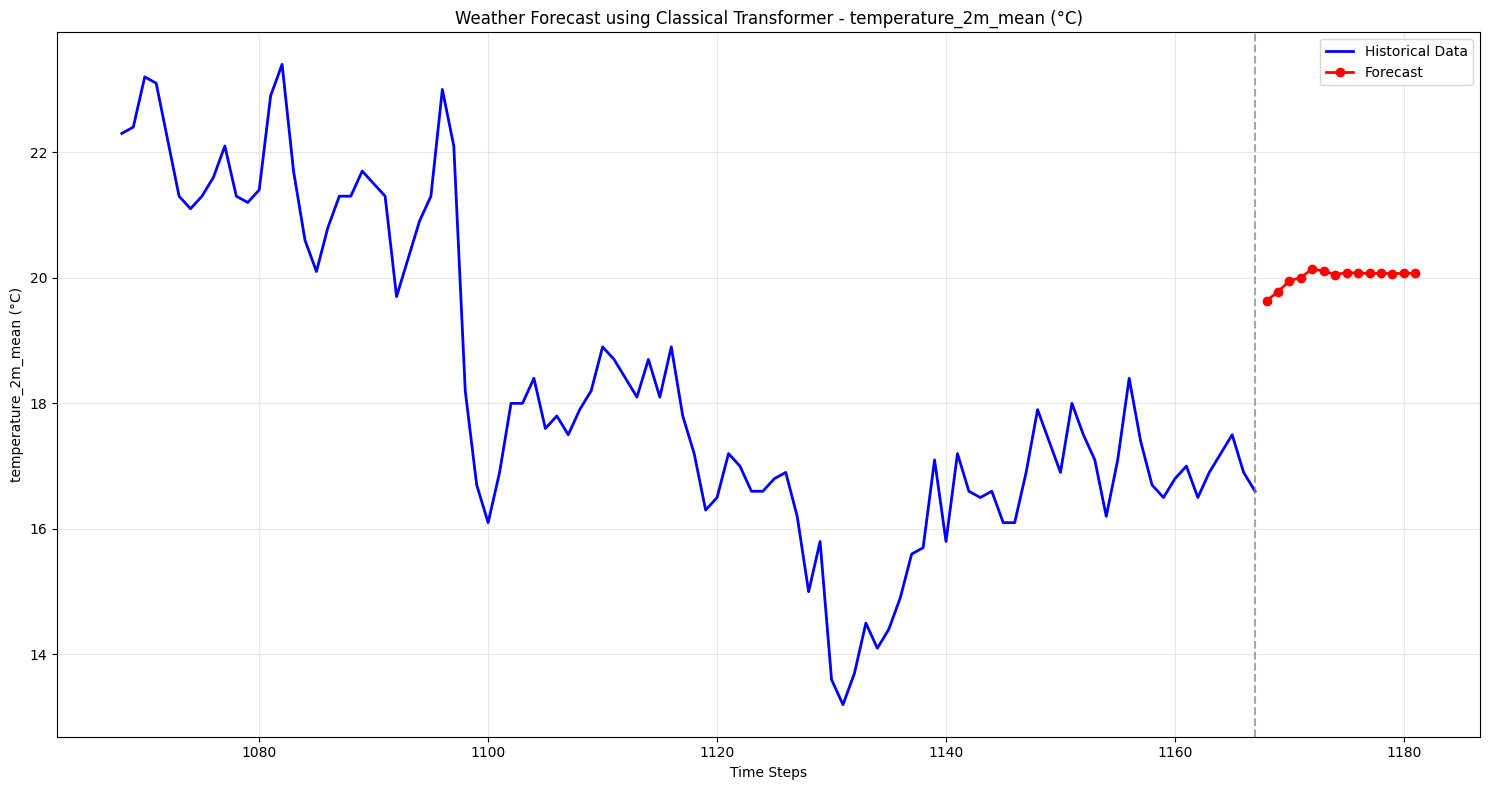

In [21]:
# Plot forecast results
plot_forecast(
    historical_data=historical_actual,
    forecasted_data=forecasted_values,
    target_name=target_col,
    n_history=100
)

In [22]:
forecast_df = pd.DataFrame({
    'Day': range(1, forecast_days + 1),
    f'Forecasted_{target_col}': forecasted_values
})

print("\n📊 Forecast Summary:")
print(forecast_df)


📊 Forecast Summary:
    Day  Forecasted_temperature_2m_mean (°C)
0     1                            19.635601
1     2                            19.776524
2     3                            19.951265
3     4                            20.004477
4     5                            20.143026
5     6                            20.105585
6     7                            20.051929
7     8                            20.081940
8     9                            20.075539
9    10                            20.070902
10   11                            20.069311
11   12                            20.068420
12   13                            20.069424
13   14                            20.069931


🚀 Running Comprehensive Forecast Evaluation...
📊 CLASSICAL TRANSFORMER FORECASTING EVALUATION REPORT

🎯 HISTORICAL PREDICTION ACCURACY (Test Set)
--------------------------------------------------
📈 R² Score (Coefficient of Determination): 0.8762
📉 Root Mean Squared Error (RMSE): 2.3444
📊 Mean Absolute Error (MAE): 1.7811
📋 Mean Absolute Percentage Error (MAPE): 8.44%
🔺 Maximum Absolute Error: 11.1490
🎯 Median Absolute Error: 1.3419
📏 Standard Deviation of Errors: 2.3272

🔍 PERFORMANCE INTERPRETATION:
   ✅ VERY GOOD: Strong predictive power
   ✅ MAPE: Good prediction accuracy

🔮 FORECAST ANALYSIS (14 days ahead)
--------------------------------------------------
📊 Forecast Statistics:
   Mean Value: 20.0124
   Standard Deviation: 0.1347
   Range: 0.5074 (Min: 19.6356, Max: 20.1430)
   Trend: 📈 INCREASING (slope: 0.021881)

🛡️  FORECAST CONFIDENCE & STABILITY
--------------------------------------------------
📊 Volatility (day-to-day changes): 0.0697
🔺 Maximum daily change: 0.1747
📈 Ave

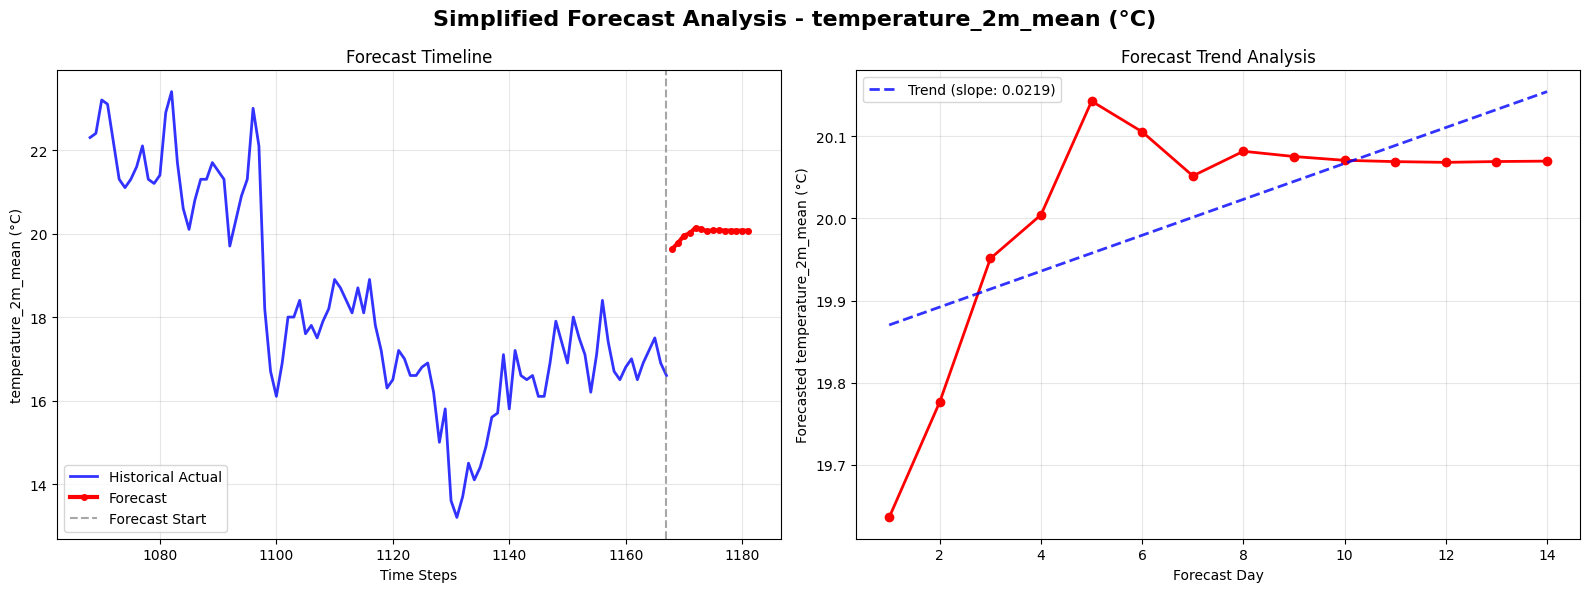


📋 SUMMARY METRICS TABLE:
                Model  R²_Score   RMSE    MAE  MAPE_%  Max_Error  Forecast_Mean  Forecast_Std  Forecast_Range  Trend_Slope  Volatility  Stability_Ratio
Classical Transformer    0.8762 2.3444 1.7811   8.442     11.149        20.0124        0.1347          0.5074       0.0219      0.0697           0.1186


In [23]:
# Forecasting Evaluation Metrics Cell

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def evaluate_forecast_performance(actual_values, predicted_values, forecast_values, 
                                forecast_horizon=14, model_name="Classical Transformer"):
    """
    Comprehensive evaluation of forecasting performance
    
    Args:
        actual_values: Historical actual values (full dataset)
        predicted_values: Model predictions on test set
        forecast_values: Future forecasted values
        forecast_horizon: Number of forecast steps
        model_name: Name of the model for reporting
    """
    print("="*70)
    print(f"📊 {model_name.upper()} FORECASTING EVALUATION REPORT")
    print("="*70)
    
    # 1. HISTORICAL PREDICTION ACCURACY (Test Set Performance)
    print("\n🎯 HISTORICAL PREDICTION ACCURACY (Test Set)")
    print("-" * 50)
    
    # Calculate metrics
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    r2 = r2_score(actual_values, predicted_values)
    
    # Additional metrics
    max_error = np.max(np.abs(actual_values - predicted_values))
    median_ae = np.median(np.abs(actual_values - predicted_values))
    std_error = np.std(actual_values - predicted_values)
    
    print(f"📈 R² Score (Coefficient of Determination): {r2:.4f}")
    print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"📊 Mean Absolute Error (MAE): {mae:.4f}")
    print(f"📋 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"🔺 Maximum Absolute Error: {max_error:.4f}")
    print(f"🎯 Median Absolute Error: {median_ae:.4f}")
    print(f"📏 Standard Deviation of Errors: {std_error:.4f}")
    
    # Performance interpretation
    print(f"\n🔍 PERFORMANCE INTERPRETATION:")
    if r2 >= 0.9:
        print("   ⭐ EXCELLENT: Very strong predictive power")
    elif r2 >= 0.8:
        print("   ✅ VERY GOOD: Strong predictive power")
    elif r2 >= 0.7:
        print("   👍 GOOD: Decent predictive power")
    elif r2 >= 0.5:
        print("   ⚠️  MODERATE: Fair predictive power")
    else:
        print("   ❌ POOR: Weak predictive power")
    
    if mape <= 5:
        print("   🎯 MAPE: Highly accurate predictions")
    elif mape <= 10:
        print("   ✅ MAPE: Good prediction accuracy")
    elif mape <= 20:
        print("   ⚠️  MAPE: Moderate prediction accuracy")
    else:
        print("   ❌ MAPE: Poor prediction accuracy")
    
    # 2. FORECAST ANALYSIS
    print(f"\n🔮 FORECAST ANALYSIS ({forecast_horizon} days ahead)")
    print("-" * 50)
    
    forecast_mean = np.mean(forecast_values)
    forecast_std = np.std(forecast_values)
    forecast_min = np.min(forecast_values)
    forecast_max = np.max(forecast_values)
    forecast_range = forecast_max - forecast_min
    
    # Calculate trend
    if len(forecast_values) > 1:
        trend_slope = np.polyfit(range(len(forecast_values)), forecast_values, 1)[0]
        if trend_slope > 0.01:
            trend_direction = "📈 INCREASING"
        elif trend_slope < -0.01:
            trend_direction = "📉 DECREASING"
        else:
            trend_direction = "➡️  STABLE"
    else:
        trend_slope = 0
        trend_direction = "➡️  SINGLE POINT"
    
    print(f"📊 Forecast Statistics:")
    print(f"   Mean Value: {forecast_mean:.4f}")
    print(f"   Standard Deviation: {forecast_std:.4f}")
    print(f"   Range: {forecast_range:.4f} (Min: {forecast_min:.4f}, Max: {forecast_max:.4f})")
    print(f"   Trend: {trend_direction} (slope: {trend_slope:.6f})")
    
    # 3. FORECAST CONFIDENCE & STABILITY
    print(f"\n🛡️  FORECAST CONFIDENCE & STABILITY")
    print("-" * 50)
    
    # Calculate stability metrics
    if len(forecast_values) > 1:
        daily_changes = np.diff(forecast_values)
        volatility = np.std(daily_changes)
        max_daily_change = np.max(np.abs(daily_changes))
        avg_daily_change = np.mean(np.abs(daily_changes))
        
        print(f"📊 Volatility (day-to-day changes): {volatility:.4f}")
        print(f"🔺 Maximum daily change: {max_daily_change:.4f}")
        print(f"📈 Average daily change: {avg_daily_change:.4f}")
        
        # Stability assessment
        historical_std = np.std(actual_values[-50:]) if len(actual_values) >= 50 else np.std(actual_values)
        stability_ratio = forecast_std / historical_std
        
        print(f"⚖️  Forecast vs Historical Variability: {stability_ratio:.2f}x")
        
        if stability_ratio <= 1.2:
            print("   ✅ STABLE: Forecast variability similar to historical")
        elif stability_ratio <= 2.0:
            print("   ⚠️  MODERATE: Forecast more variable than historical")
        else:
            print("   ❌ UNSTABLE: Forecast much more variable than historical")
    
    # 4. FORECAST VALIDATION METRICS
    print(f"\n🔬 FORECAST VALIDATION METRICS")
    print("-" * 50)
    
    # Use last few actual values to validate short-term forecast accuracy
    if len(actual_values) >= forecast_horizon:
        # Simulate forecast validation using recent history
        recent_actual = actual_values[-forecast_horizon:]
        forecast_mae_validation = np.mean(np.abs(recent_actual - np.mean(recent_actual)))
        
        print(f"📊 Recent Historical MAE (baseline): {forecast_mae_validation:.4f}")
        print(f"🎯 Model Test MAE: {mae:.4f}")
        
        if mae < forecast_mae_validation:
            print("   ✅ Model outperforms naive baseline")
        else:
            print("   ⚠️  Model performance similar to baseline")
    
    # 5. CREATE SUMMARY METRICS DICTIONARY
    metrics_summary = {
        'Model': model_name,
        'R²_Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE_%': mape,
        'Max_Error': max_error,
        'Forecast_Mean': forecast_mean,
        'Forecast_Std': forecast_std,
        'Forecast_Range': forecast_range,
        'Trend_Slope': trend_slope,
        'Volatility': volatility if len(forecast_values) > 1 else 0,
        'Stability_Ratio': stability_ratio if len(forecast_values) > 1 else 1.0
    }
    
    return metrics_summary

def plot_comprehensive_forecast_analysis(actual_values, predicted_values, forecast_values, 
                                         target_name, n_history=100):
    """
    Create simplified forecast visualization (timeline and trend only)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Simplified Forecast Analysis - {target_name}', fontsize=16, fontweight='bold')
    
    # 1. Full forecast timeline
    ax1 = axes[0]
    hist_indices = range(len(actual_values) - n_history, len(actual_values))
    hist_values = actual_values[-n_history:]
    forecast_indices = range(len(actual_values), len(actual_values) + len(forecast_values))
    
    ax1.plot(hist_indices, hist_values, 'b-', linewidth=2, label='Historical Actual', alpha=0.8)
    ax1.plot(forecast_indices, forecast_values, 'r-', linewidth=3, label='Forecast', marker='o', markersize=4)
    ax1.axvline(x=len(actual_values)-1, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
    ax1.set_title('Forecast Timeline')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel(target_name)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Forecast trend
    ax2 = axes[1]
    days = range(1, len(forecast_values) + 1)
    ax2.plot(days, forecast_values, 'ro-', linewidth=2, markersize=6)
    if len(forecast_values) > 1:
        z = np.polyfit(days, forecast_values, 1)
        p = np.poly1d(z)
        ax2.plot(days, p(days), 'b--', linewidth=2, alpha=0.8, label=f'Trend (slope: {z[0]:.4f})')
        ax2.legend()
    ax2.set_title('Forecast Trend Analysis')
    ax2.set_xlabel('Forecast Day')
    ax2.set_ylabel(f'Forecasted {target_name}')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# MAIN EVALUATION EXECUTION
# Make sure you have run the forecasting cells first!

if 'y_test_actual' in locals() and 'y_pred_test_actual' in locals() and 'forecasted_values' in locals():
    print("🚀 Running Comprehensive Forecast Evaluation...")
    
    # Run the evaluation
    metrics = evaluate_forecast_performance(
        actual_values=y_test_actual,
        predicted_values=y_pred_test_actual,
        forecast_values=forecasted_values,
        forecast_horizon=len(forecasted_values),
        model_name="Classical Transformer"
    )
    
    # Create comprehensive plots
    plot_comprehensive_forecast_analysis(
        actual_values=y_test_actual,
        predicted_values=y_pred_test_actual,
        forecast_values=forecasted_values,
        target_name=target_col,
        n_history=100
    )
    
    # Create metrics DataFrame for easy viewing
    metrics_df = pd.DataFrame([metrics])
    print("\n📋 SUMMARY METRICS TABLE:")
    print("="*70)
    print(metrics_df.round(4).to_string(index=False))
    
else:
    print("❌ Please run the model training and forecasting cells first!")
    print("Required variables: y_test_actual, y_pred_test_actual, forecasted_values, target_col")